# DREAM EXPERIMENT: data analysis of simulated events
## Angular distribution of muons

Importing modules

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optim
import scipy.stats as stats

Loading data from `positions.txt`:

In [3]:
# loading data from simulation
x,y,theta,phi = np.loadtxt("positions.txt", unpack=True, usecols=(0,1,2,3))
directions = np.loadtxt("positions.txt", unpack=True, usecols=(4,5,6))
positions = np.loadtxt("positions.txt", unpack=True, usecols=(7,8,9))

# rescaling of units: mm -> cm
x = 0.1*x
y = 0.1*y

# number of Monte Carlo events
if(len(x)==len(y)==len(theta)==len(phi)):
    print('Data are of equal length. You have {0} events'.format(len(x)))
else:
    print('There are problems in reading out data')

Data are of equal length. You have 10000 events


Theoretical distributions of randomic angles:
- Polar angle $\phi \in [0,2\pi]$:
$$p(\phi) = \frac{1}{2\pi}$$
- Azimuthal angle $\theta \in [0,\frac{\pi}{2}]$ (restriction):
$$p(\theta) = 3\cos(\theta)^2$$

In [4]:
# theoretical distribution functions of angles
def Ptheta(x):
    return 4*np.cos(x)*np.cos(x)/np.pi

# generation of samples for theta
sample_angles_theta = np.arange(0, 0.5*np.pi, 0.01)
sample_angulardistribution_theta = Ptheta(sample_angles_theta)

# generation of samples for phi
sample_angles_phi = np.arange(0, 2*np.pi, 0.01)
sample_angulardistribution_phi = [0.5/np.pi for i in np.arange(0, len(sample_angles_phi))]

Histograms of randomic angles 

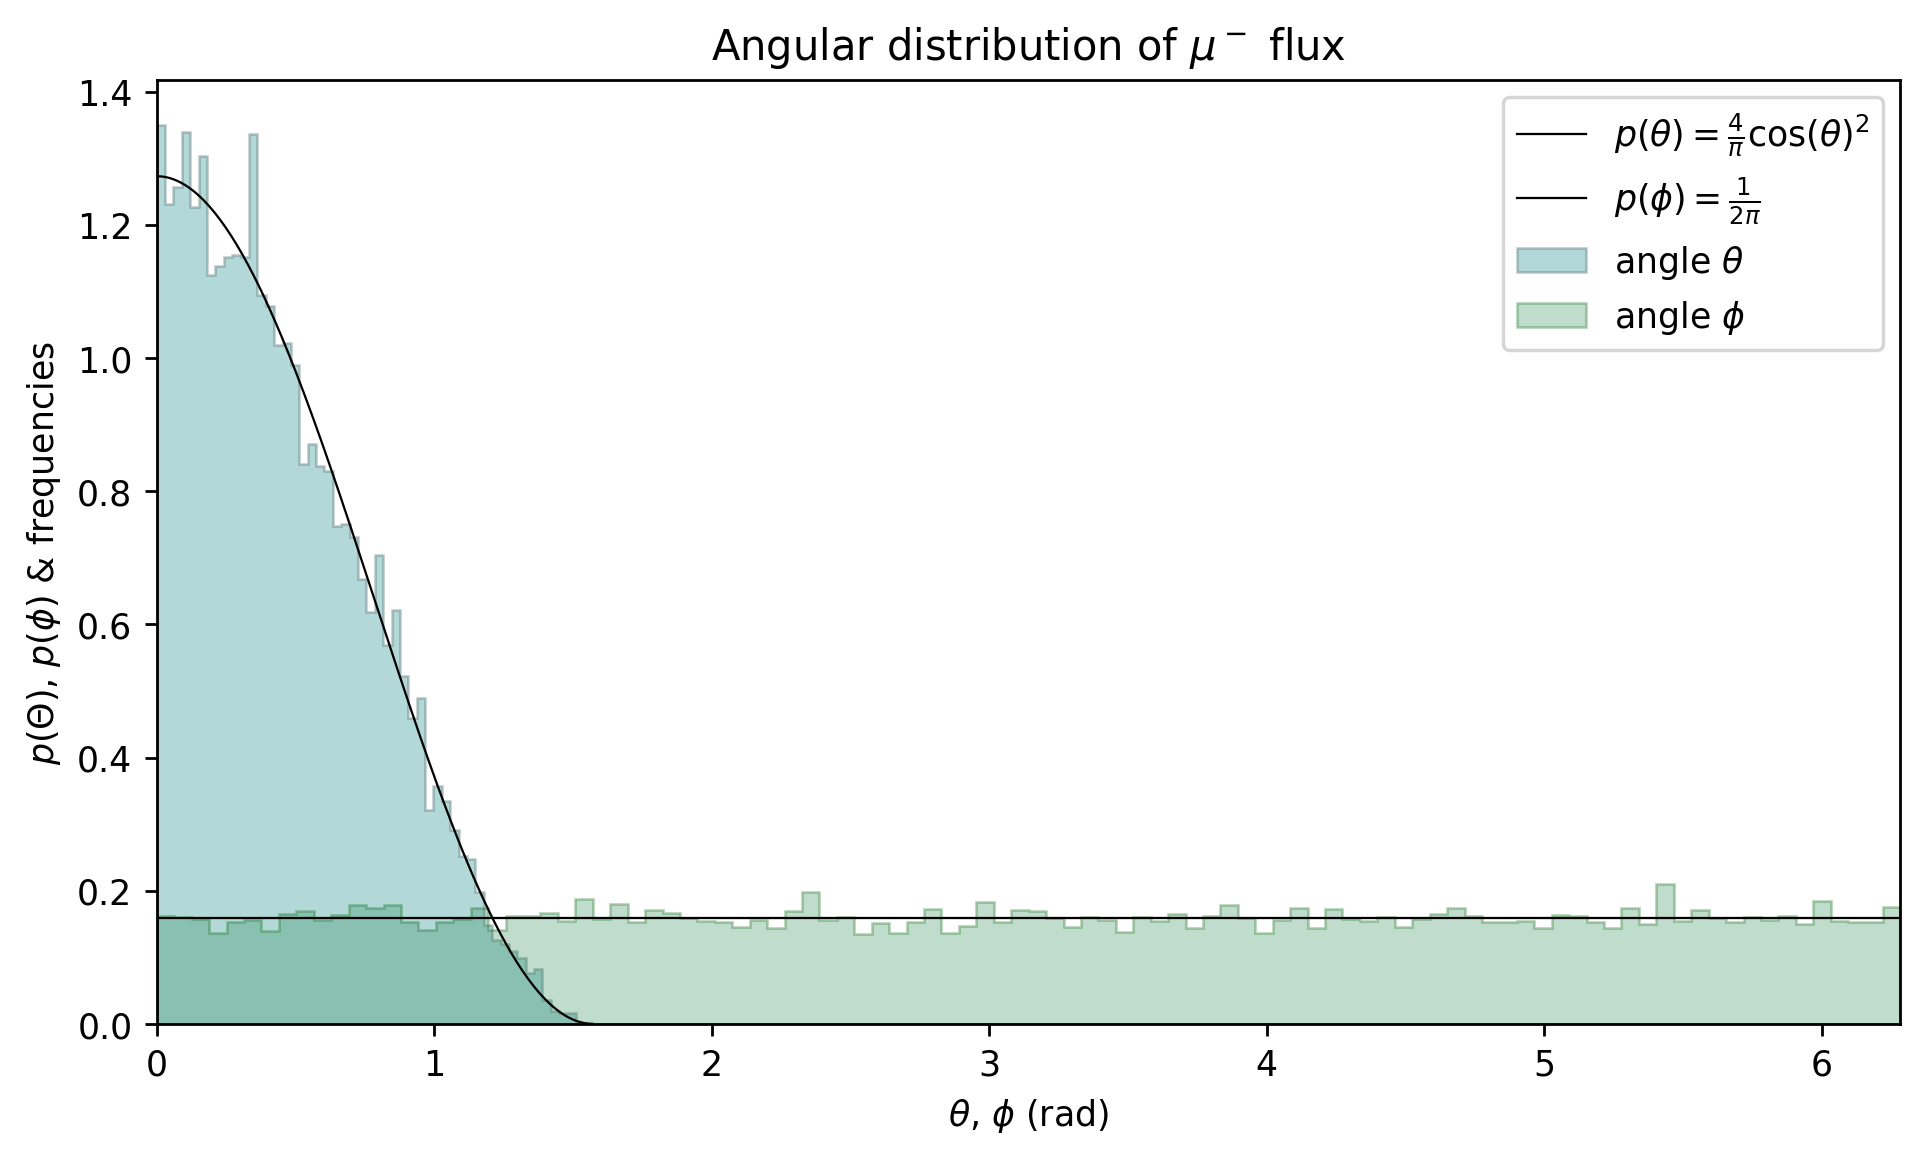

In [5]:
# prepare the figure
fig = plt.figure(111, figsize=(9,5), dpi=250)

#plot of histos & functions
plt.hist(theta, bins=50, label=r'angle $\theta$', histtype="stepfilled",
         color="teal", ec="darkslategray", alpha=0.3, lw=0.75, density=True)
plt.hist(phi, bins=100, label=r'angle $\phi$', histtype='stepfilled',
         color="seagreen", ec="darkgreen", alpha=0.3,  lw=0.75, density=True)
plt.plot(sample_angles_theta, sample_angulardistribution_theta,
         label=r'$p(\theta)=\frac{4}{\pi}\cos(\theta)^2$', lw=0.65 , color="black")
plt.plot(sample_angles_phi, sample_angulardistribution_phi,
         label=r'$p(\phi) = \frac{1}{2\pi}$', lw=0.65, color='black')

# visualize
plt.title('Angular distribution of $\mu^-$ flux')
plt.xlabel(r'$\theta$, $\phi$ (rad)')
plt.ylabel(r'$p(\Theta)$, $p(\phi)$ & frequencies')
plt.xlim(0, 2*np.pi)
plt.legend()
plt.show()
fig.savefig("AngularDistribution.jpg",bbox_inches='tight')

Histograms of randomic positions

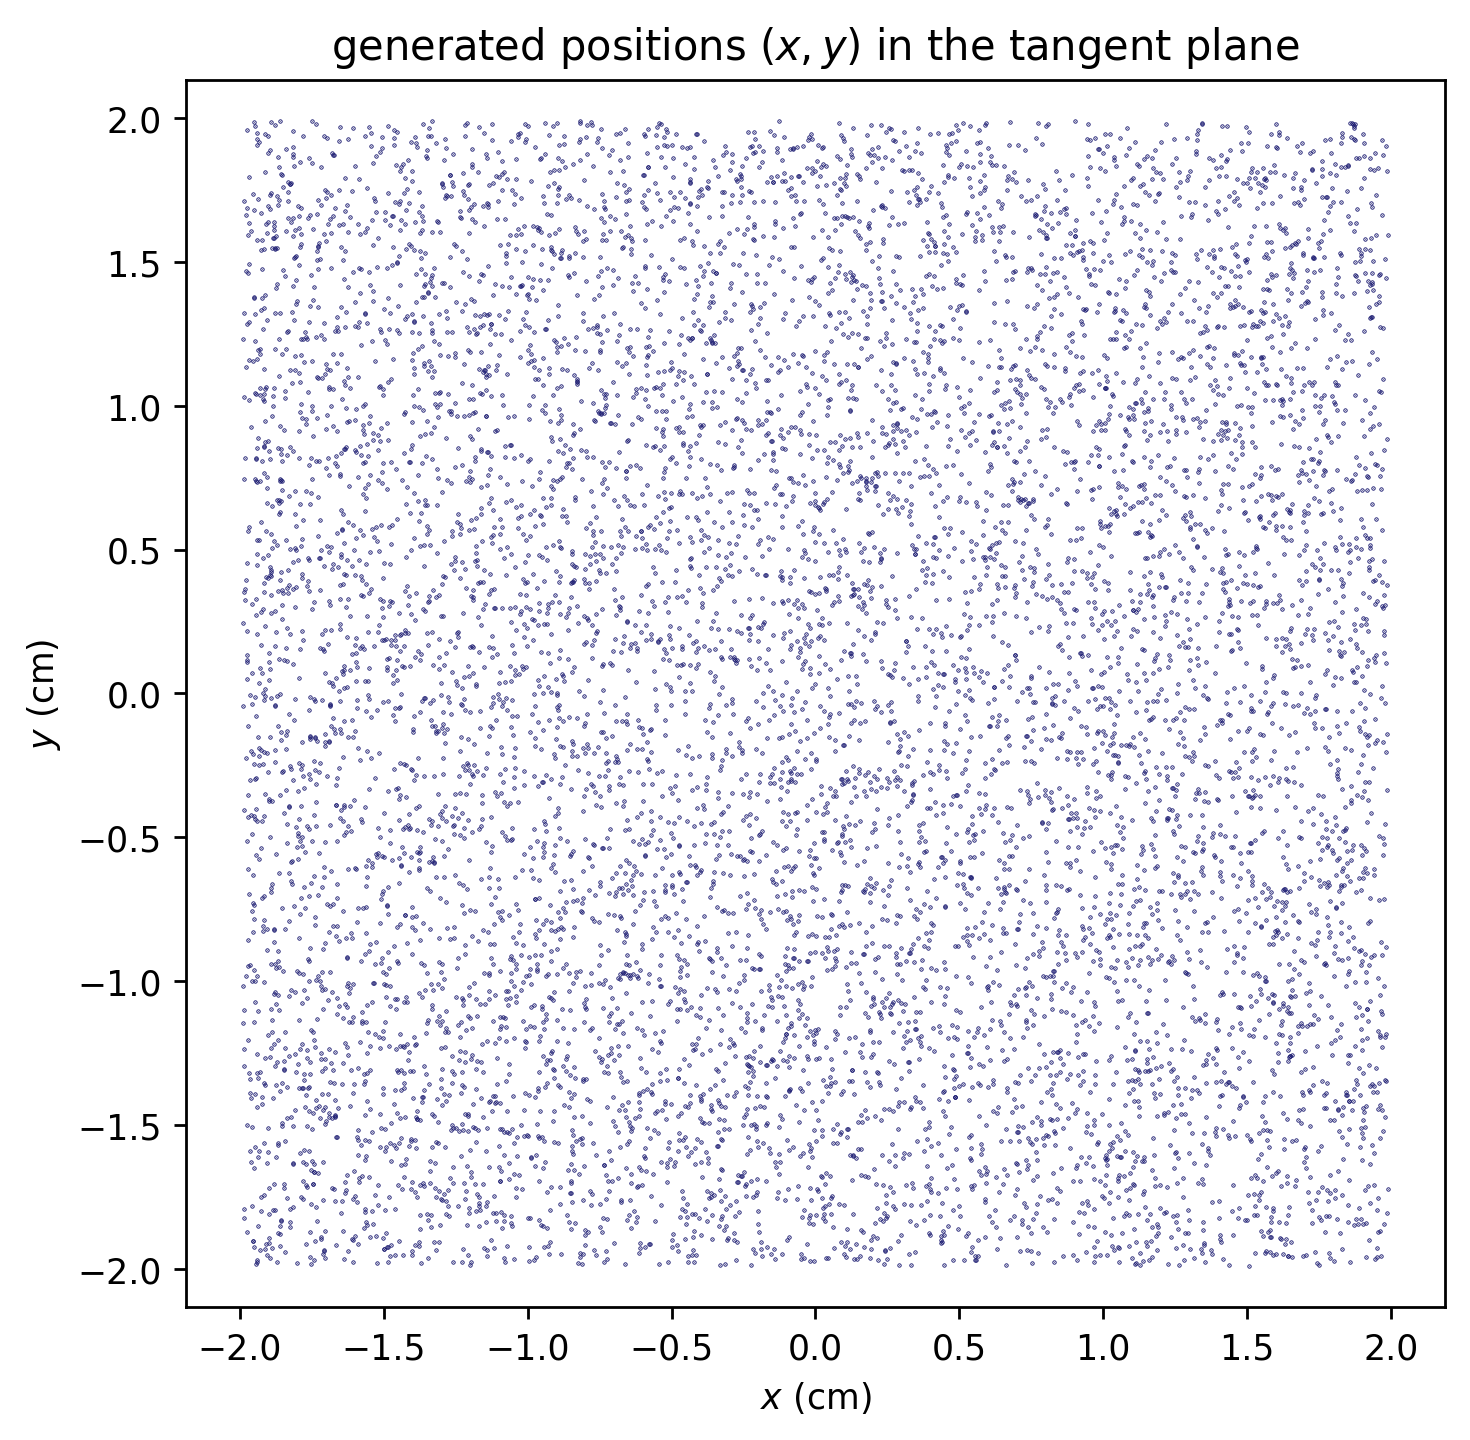

In [6]:
fig = plt.figure(111, figsize=(6.5,6.5), dpi=250)

plt.plot(x, y, marker='.', markersize=0.5, lw=0, color='midnightblue')

plt.title('generated positions $(x,y)$ in the tangent plane')
plt.xlabel('$x$ (cm)')
plt.ylabel('$y$ (cm)')
plt.xlim(min(x), max(x))
plt.ylim(min(y), max(y))
plt.axis('equal')
plt.show()
fig.savefig("RandomPositions.jpg",bbox_inches='tight')

## Energy losses in detectors

Loading data from `energies.txt`:

In [7]:
# loading data from simulation
energyBGO, energyScint1, energyScint2 = np.loadtxt("energies.txt", unpack=True, usecols=(1,2,3))

energyBGO = np.setdiff1d(energyBGO,np.array([0]))
energyScint1 = np.setdiff1d(energyScint1,np.array([0]))
energyScint2 = np.setdiff1d(energyScint2,np.array([0]))

# number of Monte Carlo events
numberofevents = len(energyBGO)
print("You have {0} data".format(numberofevents))

You have 336 data


### BGO crystal
##### Landau-Vavilov Fit:
A good limit of the Landau distribution is the Moyal pdf:
$$ p(x) = \frac{1}{\sqrt{2\pi}} \exp \left( -\frac{x-e^{-x}}{2} \right) $$

In [8]:
# Moyal distribution + parameters
def f(x,mean,form,normalization):
    return normalization*stats.moyal.pdf(form*(x-mean))

Fit:

In [9]:
# extrapolate data from histogram
bin_heights, bin_borders = np.histogram(energyBGO, bins=100, density=True)
bin_centers = bin_borders[:-1] + 0.5*np.diff(bin_borders)

# fit of the Landau-Moyal function
[mean_energyBGO, form_BGO, normalization_BGO], covariance_BGO = optim.curve_fit(f, bin_centers, bin_heights, p0=[np.mean(energyBGO),10,1])

# print results
print("Results of fit:\nmean energy = {0} +/- {1}".format(mean_energyBGO,covariance_BGO[0][0]))
print("Form factor = {0} +/- {1}".format(form_BGO,covariance_BGO[1][1]))
print("Normalization = {0} +/- {1}".format(normalization_BGO,covariance_BGO[2][2]))

Results of fit:
mean energy = 19.592849085785733 +/- 0.006238591632430952
Form factor = 0.6855619069774119 +/- 0.0007556194282836628
Normalization = 0.5915100694798662 +/- 0.0003719600740830561


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:6005: RuntimeWarning: overflow encountered in exp
  return np.exp(-0.5 * (x + np.exp(-x))) / np.sqrt(2*np.pi)


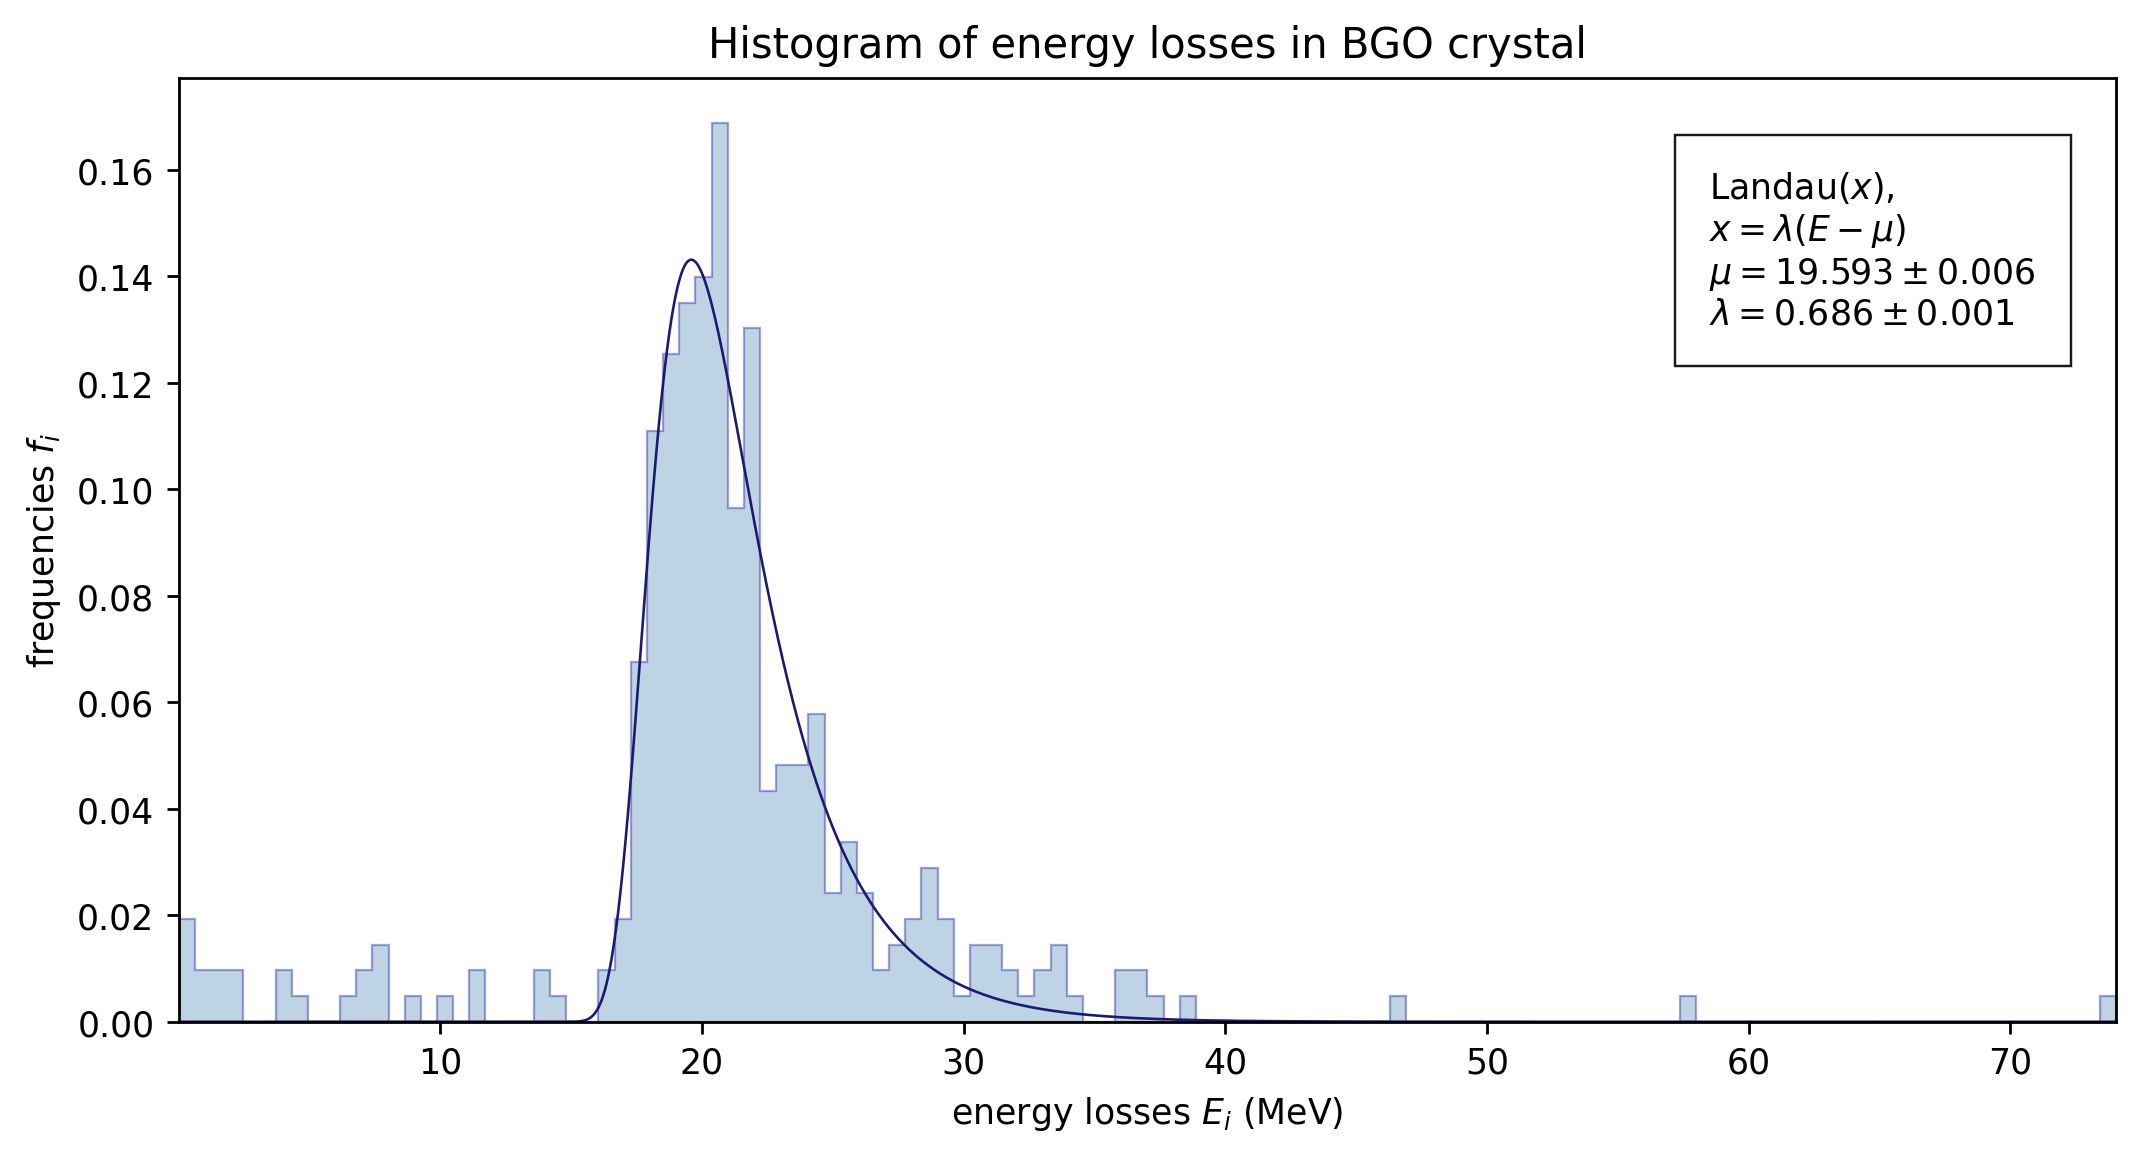

In [10]:

# prepare the figure
fig = plt.figure(111, figsize=(10,5), dpi=250)

# plot the histo
plt.hist(energyBGO, bins=120, label='BGO crystal', histtype="stepfilled",
        color='steelblue', ec='darkblue', alpha=0.35, lw=0.65, density=True)

# prepare data to plot
energy_samples = np.arange(min(energyBGO), max(energyBGO), 0.0001)
landau_samples = f(energy_samples, mean_energyBGO, form_BGO, normalization_BGO)

# plot the fitted function
plt.plot(energy_samples, landau_samples, label='Landau distribution', lw=0.75, alpha=2, color="midnightblue")

# visualize
plt.title('Histogram of energy losses in BGO crystal')
plt.xlabel('energy losses $E_i$ (MeV)')
plt.xlim(min(energyBGO), max(energyBGO))
plt.ylabel('frequencies $f_i$')
plt.text(min(energyBGO)+0.79*(max(energyBGO)-min(energyBGO)), max(bin_heights)*0.815,
         'Landau$(x)$,\n$x = \lambda(E-\mu)$\n$\mu={0:.3f} \pm {1:.3f}$\n$\lambda = {2:.3f} \pm {3:.3f}$'.format(mean_energyBGO, covariance_BGO[0][0], form_BGO, covariance_BGO[1][1]),
         bbox={'facecolor': 'white', 'alpha': 0.9, 'lw': 0.7, 'pad': 10})
plt.show()
fig.savefig("LandauBGO.jpg",bbox_inches='tight')

### Plastic scintillators
Landau-Vavilov Fit: in this case there are some $\mu^-$ ns those hit the plastic scintillators in a little region of them. This can be formally included in the analysis via an exponential decreasing function:
$$ f(E) = \lambda e^{-\lambda E} $$
and, as a consequence: $$p(E) = f(E) + Moyal(E)$$

In [11]:
# Moyal distribution + exponential one
def g(x, mean, form, normalization, alpha):
    return normalization*stats.moyal.pdf(form*(x-mean)) + alpha*np.exp(-alpha*x)

Fit:

In [12]:
# extrapolate data from histograms
bin_heights_1, bin_borders_1 = np.histogram(energyScint1, bins=150, density=True)
bin_centers_1 = bin_borders_1[:-1] + 0.5*np.diff(bin_borders_1)

bin_heights_2, bin_borders_2 = np.histogram(energyScint2, bins=150, density=True)
bin_centers_2 = bin_borders_2[:-1] + 0.5*np.diff(bin_borders_2)

# fit of the Landau-Moyal function
[mean_energy1, form_1, normalization_1, alpha_1], covariance_1 = optim.curve_fit(g,
    bin_centers_1, bin_heights_1, p0=[18, 0.745, 0.6, 0.06])
[mean_energy2, form_2, normalization_2, alpha_2], covariance_2 = optim.curve_fit(g,
    bin_centers_2, bin_heights_2, p0=[18, 0.745, 0.3, 0.12])

# print results
print("Results of fit on plastic scintillator no. 1:\nmean energy = {0} +/- {1}".format(mean_energy1,covariance_1[0][0]))
print("Form factor = {0} +/- {1}".format(form_1,covariance_1[1][1]))
print("Normalization = {0} +/- {1}".format(normalization_1,covariance_1[2][2]))
print("Alpha = {0} +/- {1}".format(alpha_1,covariance_1[3][3]))
print("\nResults of fit on plastic scintillator no. 2:\nmean energy = {0} +/- {1}".format(mean_energy2,covariance_2[0][0]))
print("Form factor = {0} +/- {1}".format(form_2,covariance_2[1][1]))
print("Normalization = {0} +/- {1}".format(normalization_2,covariance_2[2][2]))
print("Alpha = {0} +/- {1}".format(alpha_2,covariance_2[3][3]))

Results of fit on plastic scintillator no. 1:
mean energy = 18.34261702585502 +/- 0.00834608566083055
Form factor = 1.1836176505546596 +/- 0.00903669213538006
Normalization = 0.2736585430376357 +/- 0.00031647220065675455
Alpha = 0.06649269109818215 +/- 7.565774421963942e-06

Results of fit on plastic scintillator no. 2:
mean energy = 18.3219410508472 +/- 0.012217181304353333
Form factor = 1.411218072485186 +/- 0.027038586387272474
Normalization = 0.24744601361435706 +/- 0.0005410958905161088
Alpha = 0.10510696140321685 +/- 1.6909307686803618e-05


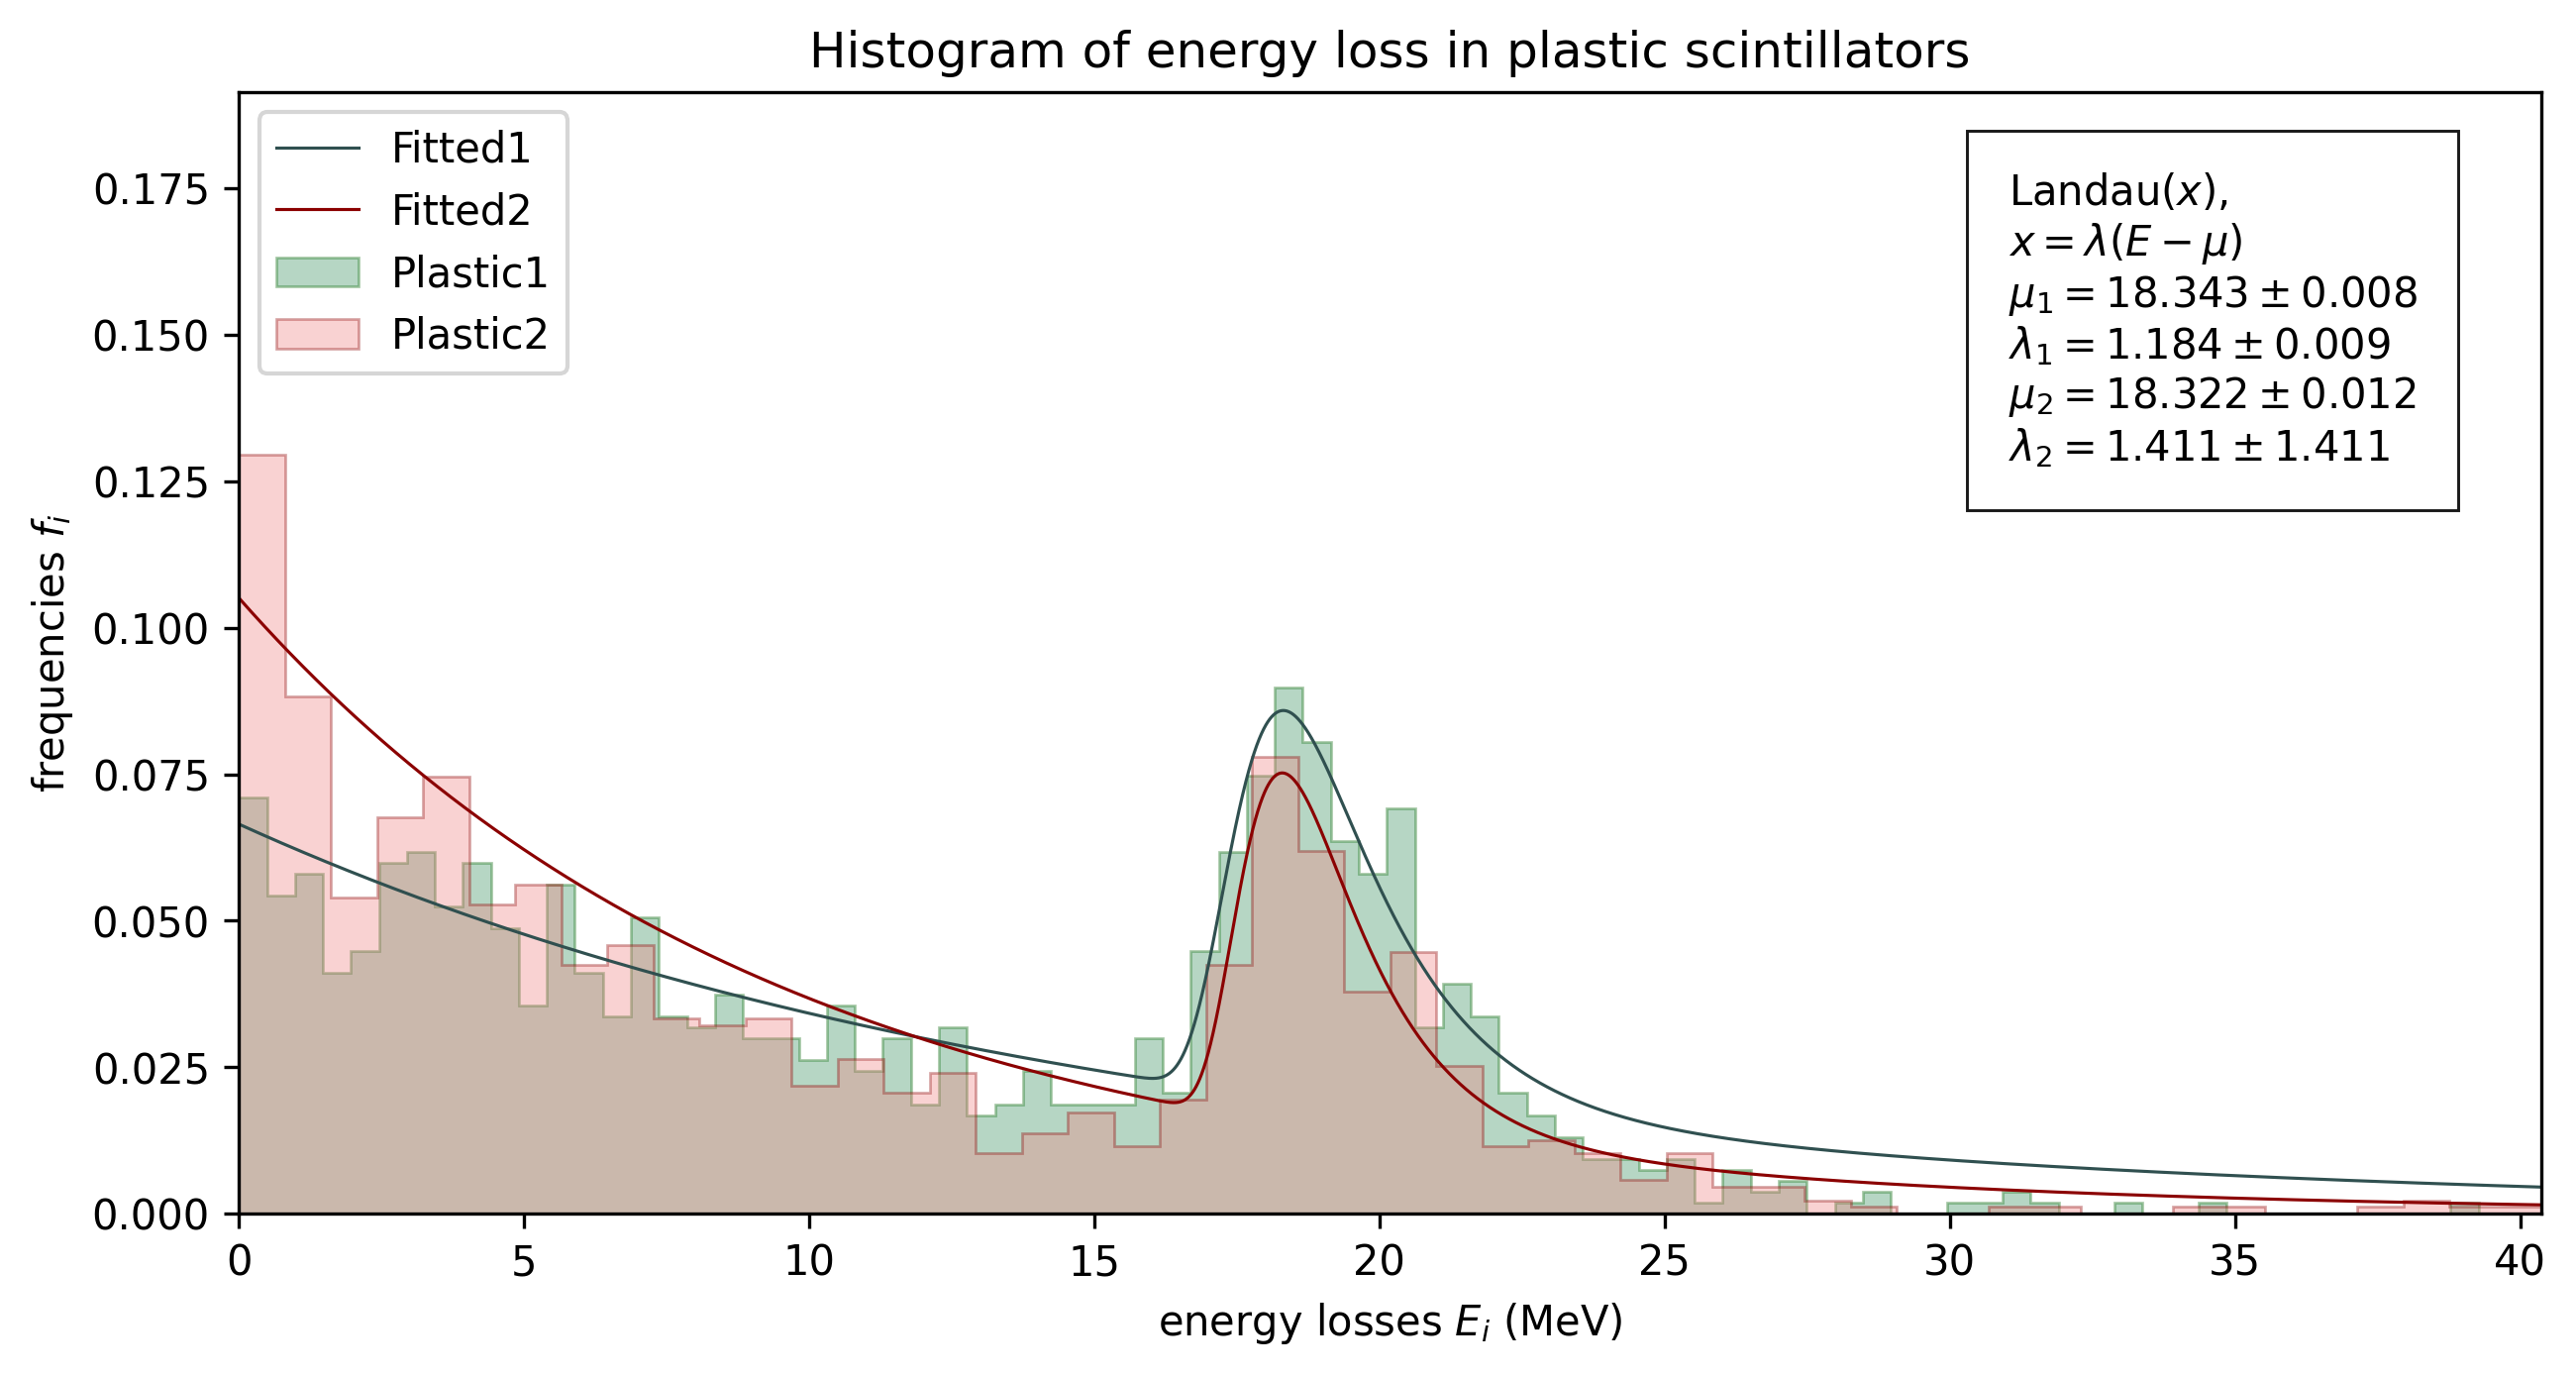

In [13]:

# prepare the figure
fig = plt.figure(111, figsize=(10,5), dpi=300)

# plot the histos
plt.hist(energyScint1, bins=80, label='Plastic1', histtype="stepfilled",
         color="seagreen", ec="darkgreen", alpha=0.35, lw=0.65, density=True)
plt.hist(energyScint2, bins=50, label='Plastic2', histtype="stepfilled",
         color="lightcoral", ec="darkred", alpha=0.35, lw=0.65, density=True)

# prepare data to plot
energy_samples = np.arange( min(min(energyScint1),min(energyScint2)), max(max(energyScint1),max(energyScint2)), 0.0001)
landauExp_samples1 = g(energy_samples, mean_energy1, form_1, normalization_1, alpha_1)
landauExp_samples2 = g(energy_samples, mean_energy2, form_2, normalization_2, alpha_2)

# plot the fitted function
plt.plot(energy_samples, landauExp_samples1, label= 'Fitted1', lw=0.75, alpha=2, color="darkslategrey")
plt.plot(energy_samples, landauExp_samples2, label= 'Fitted2', lw=0.75, alpha=2, color="darkred")

# visualize
plt.title('Histogram of energy loss in plastic scintillators')
plt.xlabel('energy losses $E_i$ (MeV)')
plt.ylabel('frequencies $f_i$')
plt.xlim(0,max(max(energyScint1),max(energyScint2)))
plt.ylim(0,max(max(bin_heights_1),max(bin_heights_2))*1.05)
plt.text(min(energyScint1)+0.79*(max(energyScint1)-min(energyScint1)), max(max(bin_heights_1),max(bin_heights_2))*0.705,
         'Landau$(x)$,\n$x = \lambda(E-\mu)$\n$\mu_1={0:.3f} \pm {1:.3f}$\n$\lambda_1 = {2:.3f} \pm {3:.3f}$\n$\mu_2={4:.3f} \pm {5:.3f}$\n$\lambda_2 = {6:.3f} \pm {6:.3f}$'.format(
             mean_energy1, covariance_1[0][0], form_1, covariance_1[1][1],mean_energy2, covariance_2[0][0], form_2, covariance_2[1][1]),
         bbox={'facecolor': 'white', 'alpha': 0.9, 'lw': 0.7, 'pad': 10})
plt.legend(loc='upper left')
plt.show()
fig.savefig("LandauPlastics.jpg",bbox_inches='tight')